<a href="https://colab.research.google.com/github/ParsecInstitute/Astromatic2022/blob/main/Problems/P2_lens_inference/P2_gravitational_lensing_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reconstructing parameters of strong gravitational lenses

## Problem description 
This project’s goal is to infer the mass and lens parameters of a sample of lensing galaxies by their gravitational distortion effect on the image of a background source. 
 
## What’s the main issue? 
With upcoming large sky surveys, hundreds of thousands of strong galaxy-galaxy gravitational lenses will be discovered. This is a challenge for characterization of individual lens systems, which can traditionally take multiple days of analysis by experts and traditional inference methods like MCMC.

## Potential solution to this problem? 
Convolutional neural networks have shown their capacity for precise and fast (~10,000,000x faster) estimation of strong lensing parameters, which makes the analysis of such a large sample of lenses feasible. Neural ratio estimation, Bayesian neural networks and many other methods make it possible to quantify uncertainties.

## Milestones
- **Craft a neural network for this problem, and its training loop.**
- **Evaluate the quality of you network**, and compare it to the literature on this subject.
- **Estimate the uncertainties** on a few parameters of interests. There are multiple approach to this, for example Bayesian Neural Networks, or Simulation-Based Inference methods. 
- **Compare your posterior** with the results of an MCMC, and calibrate your posteriors with a coverage plot. Is you network accurate? Is it precise?

## Useful references 
- [Fast Automated Analysis of Strong Gravitational Lenses with Convolutional Neural Networks, Hezaveh et al. (2017)](https://arxiv.org/abs/1708.08842).
- [Uncertainties in Parameters Estimated with Neural Networks: Application to Strong Gravitational Lensing](https://arxiv.org/abs/1708.08843)
- [Large-Scale Gravitational Lens Modeling with Bayesian Neural Networks for Accurate and Precise Inference of the Hubble Constant, Park et al. (2021)](https://arxiv.org/abs/2012.00042)
- [Simulation-Based Inference of Strong Gravitational Lensing Parameters, Legin et al (2021)](https://arxiv.org/abs/2112.05278)
- [Estimating the warm dark matter mass from strong lensing images with truncated marginal neural ratio estimation](https://arxiv.org/abs/2205.09126)
- [Likelihood-free MCMC with Amortized Approximate Ratio Estimators](https://arxiv.org/abs/1903.04057)

In [ ]:
from google.colab import drive
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from tqdm.auto import tqdm, trange
from glob import glob
import matplotlib.pylab as pylab

plt.style.use("classic")
params = {
    'legend.fontsize': 15,
    'figure.figsize': (8, 8),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 15 # for annotate
}
pylab.rcParams.update(params)
drive.mount('/content/drive')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
#@title # Simulator { display-mode: "form" }
class SIEShear:
    """
    This model produces convolved images of (pixelated or Sersic or Gaussian) background galaxy with
    a SIE+Shear lens model.
    """

    def __init__(
            self,
            pixels=128,
            image_fov=7.68,
            src_fov=3.0,
            psf_cutout_size=15,
            device=DEVICE
    ):
        self.src_fov = src_fov
        self.pixels = pixels
        self.image_fov = image_fov
        self.s_scale = image_fov / pixels / 10000  # Make profile non-singular
        # coordinates for image
        x = np.linspace(-1, 1, self.pixels) * self.image_fov / 2
        xx, yy = np.meshgrid(x, x)
        # reshape for broadcast to [batch_size, x and y, pixels, pixels]
        self.theta1 = torch.Tensor(xx).view(1, 1, pixels, pixels).to(device)
        self.theta2 = torch.Tensor(yy).view(1, 1, pixels, pixels).to(device)
        # coordinates for psf
        self.r_squared = self.theta1 ** 2 + self.theta2 ** 2
        self.r_squared = T.CenterCrop(psf_cutout_size)(self.r_squared)

    def sersic_source(self, beta1, beta2, xs, ys, q, phi_s, n, r_eff, I_eff):
        bn = 2 * n - 1 / 3  # approximate solution to gamma(2n;b_n) = 0.5 * Gamma(2n) for n > 0.36
        # shift and rotate coordinates to major/minor axis system
        beta1 = beta1 - xs
        beta2 = beta2 - ys
        beta1, beta2 = self._rotate(beta1, beta2, phi_s)
        r = torch.sqrt(beta1 ** 2 + beta2 ** 2 / q ** 2)
        return I_eff * torch.exp(-bn * (r / r_eff) ** (1 / n) - 1)

    # =============== Sersic Source ========================
    def lens_source_sersic_func(
            self,
            r_ein = 1.,
            q = 1.,
            phi = 0.,
            x0 = 0.,
            y0 = 0.,
            gamma_ext = 0.,
            phi_ext = 0.,
            xs = 0.,
            ys = 0.,
            qs = 1.,
            phi_s = 0.,
            n = 1,  # 1=exponential profile for disc, 4=de Vaucouleur
            r_eff = 0.1,
            I_eff = 10.
    ):
        if q > 0.95:
            alpha1, alpha2 = torch.tensor_split(self.approximate_deflection_angles(r_ein, q, phi, x0, y0), 2, dim=-1)
        else:
            alpha1, alpha2 = torch.tensor_split(self.analytical_deflection_angles(r_ein, q, phi, x0, y0), 2, dim=-1)
        alpha1_ext, alpha2_ext = self.external_shear_deflection(gamma_ext, phi_ext)
        # lens equation
        beta1 = self.theta1 - alpha1 - alpha1_ext
        beta2 = self.theta2 - alpha2 - alpha2_ext
        im = self.sersic_source(beta1, beta2, xs, ys, qs, phi_s, n, r_eff, I_eff)
        return im

    def lens_source_sersic_func_vec(self, x):
        # assume x has shape [batch_size, 13]
        r_ein, q, phi, x0, y0, gamma_ext, phi_ext, xs, ys, qs, phi_s, n, r_eff, I_eff = [_x[:, None, None] for _x in torch.split(x, 1, dim=1)]
        alpha1, alpha2 = torch.tensor_split(
            torch.where(q < 0.95,
                     self.analytical_deflection_angles(r_ein, q, phi, x0, y0),
                     self.approximate_deflection_angles(r_ein, q, phi, x0, y0)
        ), 2, dim=-1)
        alpha1_ext, alpha2_ext = self.external_shear_deflection(gamma_ext, phi_ext)
        # lens equation
        beta1 = self.theta1 - alpha1 - alpha1_ext
        beta2 = self.theta2 - alpha2 - alpha2_ext
        im = self.sersic_source(beta1, beta2, xs, ys, qs, phi_s, n, r_eff, I_eff)
        return im

    # =============== Sersic Source + Lens light ========================
    def lens_source_plus_lens_light_func(
            self,
            # lens params
            r_ein = 1.,
            q = 1.,
            phi = 0.,
            x0 = 0.,
            y0 = 0.,
            gamma_ext = 0.,
            phi_ext = 0.,
            # sersic source params
            xs = 0.,
            ys = 0.,
            qs = 1.,
            phi_s = 0.,
            n = 1,  # 1=exponential profile for disc, 4=de Vaucouleur
            r_eff = 0.1,
            I_eff = 10.,
            # sersic lens light params
            n_lens_light = 1,
            r_eff_lens_light = 1,
            amp_lens_light = 50.

    ):
        if q > 0.95:
            alpha1, alpha2 = torch.tensor_split(self.approximate_deflection_angles(r_ein, q, phi, x0, y0), 2, dim=-1)
        else:
            alpha1, alpha2 = torch.tensor_split(self.analytical_deflection_angles(r_ein, q, phi, x0, y0), 2, dim=-1)
        alpha1_ext, alpha2_ext = self.external_shear_deflection(gamma_ext, phi_ext)
        # lens equation
        beta1 = self.theta1 - alpha1 - alpha1_ext
        beta2 = self.theta2 - alpha2 - alpha2_ext
        im = self.sersic_source(beta1, beta2, xs, ys, qs, phi_s, n, r_eff, I_eff)  # background source
        im += self.sersic_source(self.theta1, self.theta2, x0, y0, q, phi, n_lens_light, r_eff_lens_light, amp_lens_light) # lens light
        return im

    def lens_source_plus_lens_light_vec(self, x):
        # assume x has shape [batch_size, 13]
        r_ein, q, phi, x0, y0, gamma_ext, phi_ext, xs, ys, qs, phi_s, n, r_eff, I_eff, n_lens_light, r_eff_lens_light, amp_lens_light = [_x[:, None, None] for _x in torch.split(x, 1, dim=1)]
        alpha1, alpha2 = torch.tensor_split(
            torch.where(q < 0.95,
                     self.analytical_deflection_angles(r_ein, q, phi, x0, y0),
                     self.approximate_deflection_angles(r_ein, q, phi, x0, y0)
        ), 2, dim=-1)
        alpha1_ext, alpha2_ext = self.external_shear_deflection(gamma_ext, phi_ext)
        # lens equation
        beta1 = self.theta1 - alpha1 - alpha1_ext
        beta2 = self.theta2 - alpha2 - alpha2_ext
        im = self.sersic_source(beta1, beta2, xs, ys, qs, phi_s, n, r_eff, I_eff) # background source
        im += self.sersic_source(self.theta1, self.theta2, x0, y0, q, phi, n_lens_light, r_eff_lens_light, amp_lens_light) # lens light
        return im

    # =================== Utility functions ======================

    def psf_model(self, psf_fwhm: float):
        psf_sigma = psf_fwhm / (2 * np.sqrt(2. * np.log(2.)))
        psf = torch.exp(-0.5 * self.r_squared / psf_sigma ** 2)
        psf /= torch.sum(psf, dim=(1, 2, 3), keepdim=True)
        return psf

    def convolve_with_psf(self, images, psf):
        B, C, *D = images.shape
        # stack channel dim in batch size, since we want them to be independent
        out = F.conv2d(images.view(B * C, 1, *D), psf, stride=1, padding="same")
        return out.view(B, C, *D)

    def src_coord_to_pix(self, x, y):
        dx = self.src_fov / (self.pixels - 1)
        xmin = -0.5 * self.src_fov
        ymin = -0.5 * self.src_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def external_shear_deflection(self, gamma_ext, phi_ext):
        # see Meneghetti Lecture Scripts equation 3.83 (constant shear equation)
        alpha1 = gamma_ext * (self.theta1 * np.cos(phi_ext) + self.theta2 * np.sin(phi_ext))
        alpha2 = gamma_ext * (-self.theta1 * np.sin(phi_ext) + self.theta2 * np.cos(phi_ext))
        return alpha1, alpha2

    def approximate_deflection_angles(self, r_ein, q, phi, x0, y0):
        b, s = self._param_conv(q, r_ein)
        # rotate to major/minor axis coordinates
        theta1, theta2 = self.rotated_and_shifted_coords(x0, y0, phi)
        psi = torch.sqrt(q ** 2 * (s ** 2 + theta1 ** 2) + theta2 ** 2)
        alpha1 = b * theta1 / (psi + s)
        alpha2 = b * theta2 / (psi + q**2 * s)
        # # rotate back to original orientation of coordinate system
        alpha1, alpha2 = self._rotate(alpha1, alpha2, -phi)
        return torch.concat([alpha1, alpha2], dim=-1)  # stack alphas into tensor of shape [batch_size, 2, pix, pix]

    def analytical_deflection_angles(self, r_ein, q, phi, x0, y0):
        b, s = self._param_conv(q, r_ein)
        # rotate to major/minor axis coordinates
        theta1, theta2 = self.rotated_and_shifted_coords(x0, y0, phi)
        psi = torch.sqrt(q ** 2 * (s ** 2 + theta1 ** 2) + theta2 ** 2)
        alpha1 = b / np.sqrt(1. - q ** 2) * torch.atan(np.sqrt(1. - q ** 2) * theta1 / (psi + s))
        alpha2 = b / np.sqrt(1. - q ** 2) * torch.atanh(np.sqrt(1. - q ** 2) * theta2 / (psi + s * q ** 2))
        # # rotate back
        alpha1, alpha2 = self._rotate(alpha1, alpha2, -phi)
        return torch.concat([alpha1, alpha2], dim=-1)

    def rotated_and_shifted_coords(self, x0, y0, phi):
        ###
        # Important to shift then rotate, we move to the point of view of the
        # lens before rotating the lens (rotation and translation are not commutative).
        ###
        theta1 = self.theta1 - x0
        theta2 = self.theta2 - y0
        rho = torch.sqrt(theta1 ** 2 + theta2 ** 2)
        varphi = torch.atan2(theta2, theta1) - phi
        theta1 = rho * torch.cos(varphi)
        theta2 = rho * torch.sin(varphi)
        return theta1, theta2

    @staticmethod
    def _rotate(x, y, angle):
        return x * np.cos(angle) + y * np.sin(angle), -x * np.sin(angle) + y * np.cos(angle)

    def _param_conv(self, q, r_ein):
        r_ein_conv = 2. * q * r_ein / np.sqrt(1. + q ** 2)
        b = r_ein_conv * np.sqrt((1 + q ** 2) / 2)
        s = self.s_scale * np.sqrt((1 + q ** 2) / (2 * q ** 2))
        return b, s

    @staticmethod
    def _qphi_to_ellipticity(q, phi):
        e1 = (1. - q) / (1. + q) * torch.cos(2 * phi)
        e2 = (1. - q) / (1. + q) * torch.sin(2 * phi)
        return e1, e2

    @staticmethod
    def _ellipticity_to_qphi(e1, e2):
        phi = np.atan2(e2, e1) / 2
        c = np.sqrt(e1 ** 2 + e2 ** 2)
        q = (1 - c) / (1 + c)
        return q, phi

    @staticmethod
    def _shear_polar_to_cartesian(r, phi):
        x = r * torch.cos(2 * phi)
        y = r * torch.sin(2 * phi)
        return x, y

    @staticmethod
    def _shear_cartesian_to_polar(x, y):
        r = torch.sqrt(x ** 2 + y ** 2)
        phi = torch.atan2(y, x) / 2
        return r, phi


# Exploration of the problem

Define prior bounds on the parameters we are going to use to simulate gravitational lenses. In principle, you should not touch these priors, unless you want to make the problem easier.

In [ ]:
PRIORS_BOUNDS = {
    # Singular Isothermal Elliptical Profile parameters
  "r_ein": (0.5, 2), # Einstein radius (arcsec)
  "q": (0.3, 1), # axis ratio (1 = circle, 0 < q < 1 is an ellipse)
  "phi": (0, np.pi),  # orientation of the ellipse [0, 2pi]
  "x0": (-0.1, 0.1),  # x coordinate of the lens (arcsec)
  "y0": (-0.1, 0.1),  # y coordinate of the lens (arcsec)
  "gamma_ext": (0., 0.05), # amplitude of the constant shear field
  "phi_ext": (0, np.pi),  # orientation of the constant shear field
  # sersic source params
  "xs": (-0.2, 0.2),        # x coordinate of the source (arcsec)
  "ys": (-0.2, 0.2),        # y coordinate of the source (arcsec)
  "qs": (0.3, 1),           # axis ratio of the source Sérsic profile
  "phi_s": (0, np.pi),       # Orientation of the source Sérsic profile
  "n": (0.5, 2),            # Sérsic index (1=exponential profile for disc, 4=de Vaucouleur for bulge)
  "r_eff": (0.1, 0.3),      # Effective radius of the source (arcsec)
  "I_eff": (10, 20),        # Effective intensity of the source
  # sersic lens light params
  "n_lens_light": (0.5, 2), # Sérsic index of the lens light
  "r_eff_lens_light": (0.7, 1.2), # Effective radius of the lens light
  "amp_lens_light": (50, 60), # Effective amplitude of the lens light
}


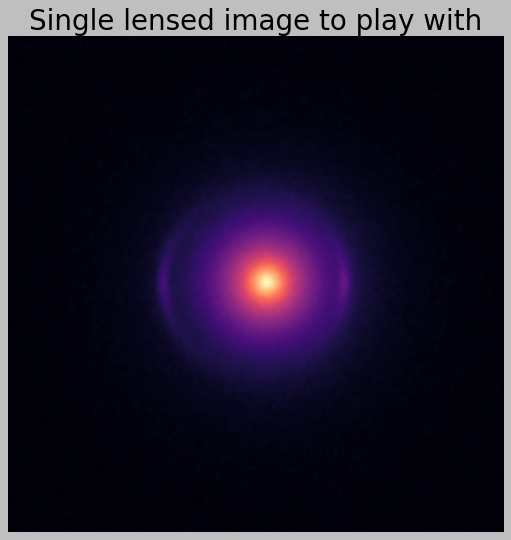

In [ ]:
simulator = SIEShear(pixels=128, image_fov=7.68, src_fov=3., psf_cutout_size=15, device=DEVICE)
lensed_image = simulator.lens_source_plus_lens_light_func(
            # Singular Isothermal Elliptical Profile parameters
            r_ein = 1., # Einstein radius (arcsec)
            q = 1.,     # axis ratio (1 = circle, 0 < q < 1 is an ellipse)
            phi = 0.,   # orientation of the ellipse [0, 2pi]
            x0 = 0.2,    # x coordinate of the lens (arcsec)
            y0 = 0.,    # y coordinate of the lens (arcsec)
            gamma_ext = 0., # amplitude of the constant shear field
            phi_ext = 0.,   # orientation of the constant shear field
            # sersic source params
            xs = 0.,    # x coordinate of the source (arcsec)
            ys = 0.,    # y coordinate of the source (arcsec)
            qs = 1.,    # axis ratio of the source Sérsic profile
            phi_s = 0., # Orientation of the source Sérsic profile
            n = 1,      # Sérsic index (1=exponential profile for disc, 4=de Vaucouleur for bulge)
            r_eff = 0.1, # Effective radius of the source (arcsec)
            I_eff = 10., # Effective intensity of the source
            # sersic lens light params
            n_lens_light = 1, # Sérsic index of the lens light
            r_eff_lens_light = 1, # Effective radius of the lens light
            amp_lens_light = 50., # Effective amplitude of the lens light
)
psf = simulator.psf_model(psf_fwhm=0.06)
# apply psf first, then noise
lensed_image = simulator.convolve_with_psf(lensed_image, psf)
lensed_image += torch.normal(mean=torch.zeros_like(lensed_image), std=0.1)

im = plt.imshow(lensed_image[0, 0, ...], cmap="magma")
plt.axis("off");
plt.title("Single lensed image to play with");

# Datasets

In [ ]:
# These are the names of the parameters in the labels returned by generate_batch
list_of_simulator_params = [
  "r_ein",
  "q",
  "phi",
  "x0",
  "y0",
  "gamma_ext",
  "phi_ext",
  "xs",
  "ys",
  "qs",
  "phi_s",
  "n",
  "r_eff",
  "I_eff",
  "n_lens_light",
  "r_eff_lens_light",
  "amp_lens_light",
]

class SimulatorDataset:
    def __init__(self, simulator, lens_light=False, psf_fwhm=0.05, noise_std=0.1, device=DEVICE):
        self.simulator = simulator
        self.psf = simulator.psf_model(psf_fwhm)
        self.noise_std = noise_std
        self.lens_light = lens_light
        if lens_light:
            self.lensing_func = simulator.lens_source_plus_lens_light_vec
        else:
            self.lensing_func = simulator.lens_source_sersic_func_vec

    def generate_batch(self, batch_size):
        x = torch.concat(
            [torch.rand(size=(batch_size, 1)) * (PRIORS_BOUNDS[p][1] - PRIORS_BOUNDS[p][0]) + PRIORS_BOUNDS[p][0] 
             for p in list_of_simulator_params[:None if self.lens_light else -3]],
            dim=1
        )
        lensed_image = self.lensing_func(x)
        lensed_image = self.simulator.convolve_with_psf(lensed_image, self.psf)
        lensed_image += torch.normal(mean=torch.zeros_like(lensed_image), std=self.noise_std)
        return lensed_image, x # INPUT, LABELS

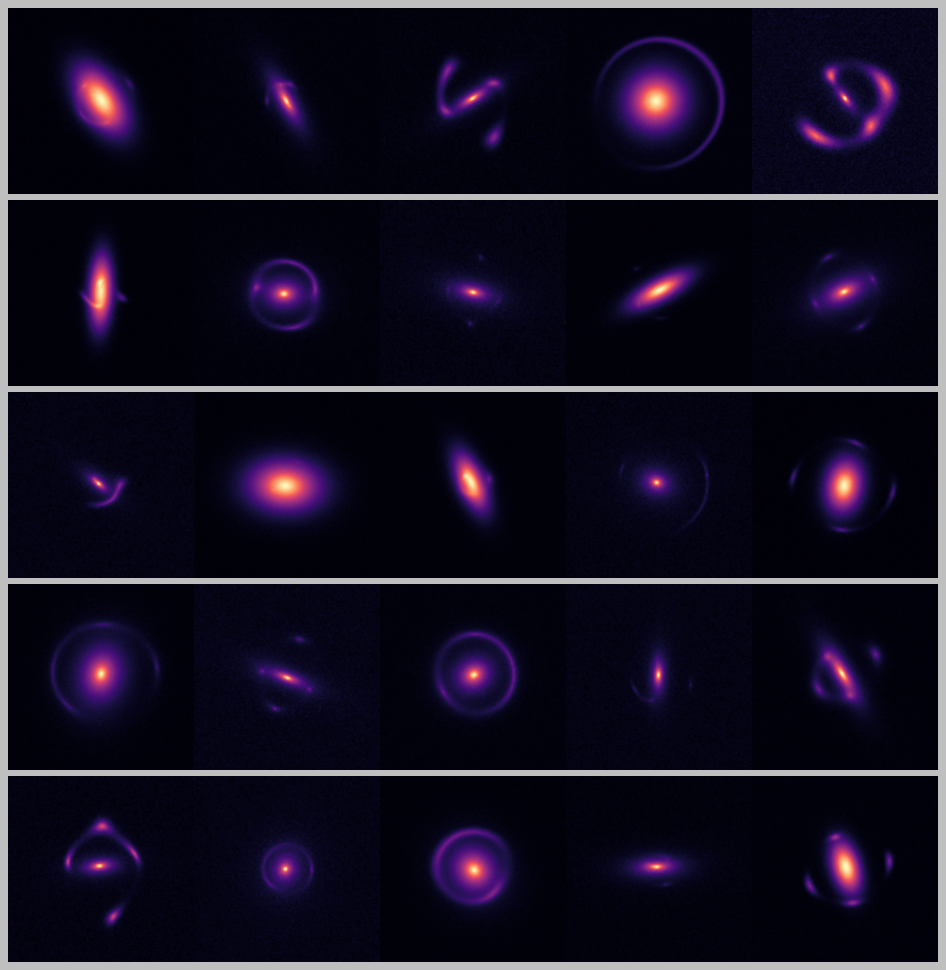

In [ ]:
simulator = SIEShear(pixels=128, image_fov=7.68, src_fov=3., psf_cutout_size=15, device=DEVICE)
dataset = SimulatorDataset(simulator, lens_light=True)
im, y = dataset.generate_batch(5**2)

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
  for j in range(5):
    k = i * 5 + j
    axs[i, j].imshow(im[k, 0], cmap="magma")
    axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)

# Infer the mass of a lensing galaxy given a lensed image

In [ ]:
from torch import nn


# TODO: define network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, obs):
        ...

In [ ]:
# Initialize simulator
simulator = SIEShear(pixels=128, image_fov=7.68, src_fov=3., psf_cutout_size=15, device=DEVICE)
dataset = SimulatorDataset(simulator, lens_light=True)

# Initialize network
network = Network()
network.to(DEVICE)  # move network to GPU

# TODO: set up network, optimizer, loss function
n_epochs = 2
batch_size = 64
network.train()
for epoch in trange(n_epochs):  # progress bar
    im, y = dataset.generate_batch(batch_size)  # observation, labels
    # TODO: do something!

network.eval()

  0%|          | 0/2 [00:00<?, ?it/s]

Network()